In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier as RFR
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.model_selection import train_test_split, GridSearchCV


from sklearn.pipeline import Pipeline

# score
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mariam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
df = pd.read_csv('spam_ham_dataset.csv')

In [79]:
df

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [80]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [82]:
df.describe()

,Unnamed: 0,label_num
count,5171.000000,5171.000000
mean,2585.000000,0.289886
std,1492.883452,0.453753
min,0.000000,0.000000
25%,1292.500000,0.000000
50%,2585.000000,0.000000
75%,3877.500000,1.000000
max,5170.000000,1.000000


In [83]:
df.shape

(5171, 4)

In [84]:
df.isnull().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

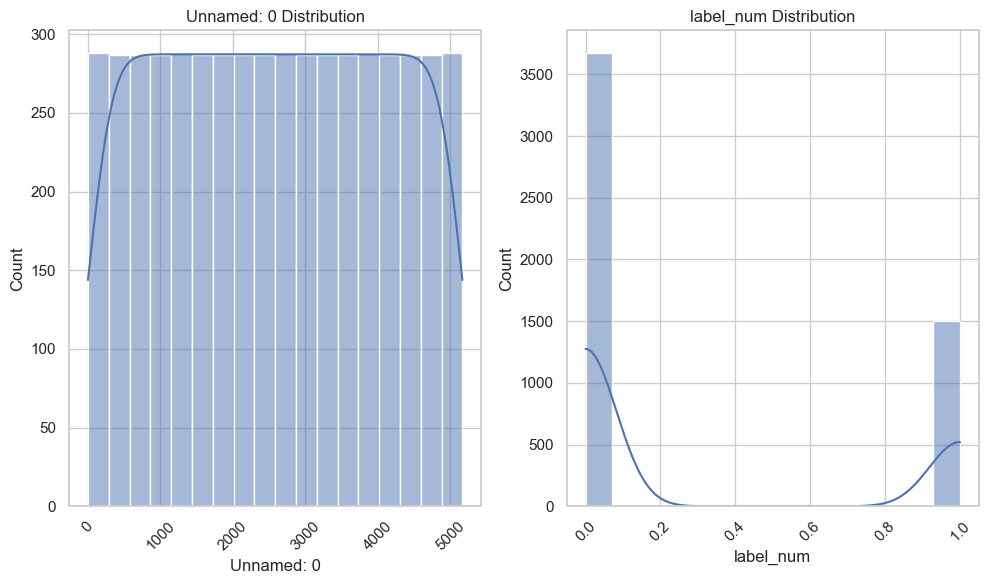

In [85]:
sns.set(style="whitegrid")
numerical_columns = df.select_dtypes(include=['int64']).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
num_cols = len(numerical_columns)
num_rows = -(-num_cols // 4) 

plt.figure(figsize=(20, 6 * num_rows))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 4, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

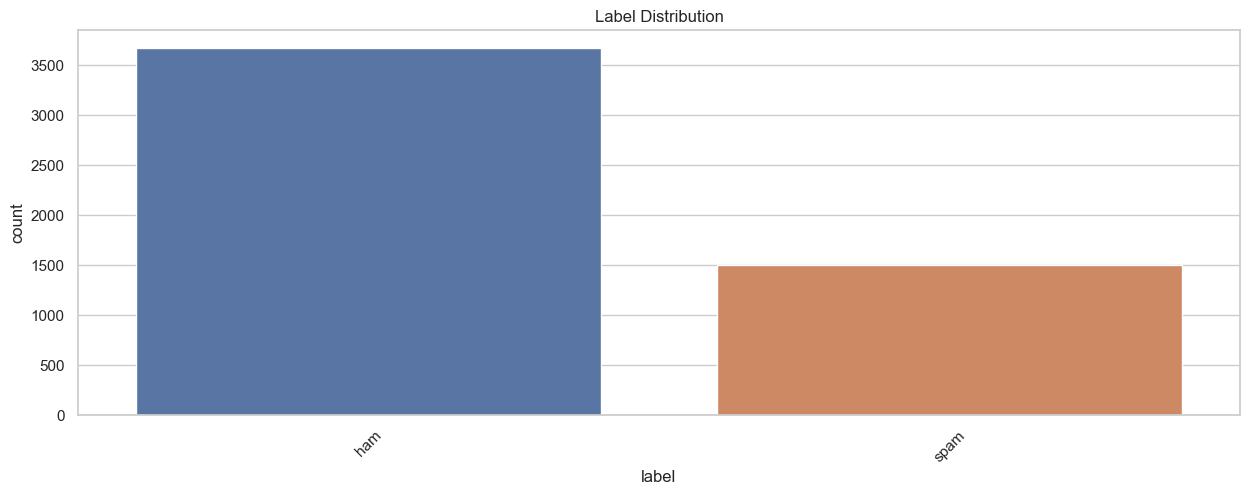

In [86]:
plt.figure(figsize=(15, 5))
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.xticks(rotation=45)
plt.show()

In [87]:
df[["label","label_num"]].groupby(["label"], as_index = False).mean().sort_values(by="label_num",ascending = False)

,label,label_num
1,spam,1.0
0,ham,0.0


In [88]:
df[["text","label_num"]].groupby(["text"], as_index = False).mean().sort_values(by="label_num",ascending = False)

,text,label_num
0,Subject: \r\n,1.0
4267,Subject: select eshopping for medicines and ta...,1.0
4242,Subject: satisfy her nj 2 w\r\nclick here to b...,1.0
4243,Subject: save 70 percent on super viagra 24663...,1.0
4244,Subject: save a bundle on meds !\r\nfont color...,1.0
...,...,...
2018,"Subject: hpl nom for march 1 , 2001\r\n( see a...",0.0
2019,"Subject: hpl nom for march 10 - 12 , 2001\r\n(...",0.0
2020,"Subject: hpl nom for march 13 , 2001\r\n( see ...",0.0
2021,"Subject: hpl nom for march 15 , 2001\r\n( see ...",0.0


In [89]:
df.duplicated().sort_values(ascending=False)

0       False
3474    False
3452    False
3451    False
3450    False
        ...  
1722    False
1721    False
1720    False
1719    False
5170    False
Length: 5171, dtype: bool

In [90]:
ps = PorterStemmer()
corpus = []

all_stop_words = set(stopwords.words('english'))
all_stop_words.remove('not')

for i in range (len(df)):
    text = df['text'][i].lower().translate(str.maketrans('','', string.punctuation)).split()
    text = [ps.stem(word) for word in text if word not in all_stop_words]
    text = ' '.join(text)
    corpus.append(text)

In [91]:
cv = CountVectorizer(max_features= 42500)
X = cv.fit_transform(corpus).toarray()
y = df['label_num']

In [92]:
len(X[0])

42500

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [94]:
def model_score(y_true,y_pred):
    acc_scor = accuracy_score(y_true, y_pred)
    prec_scor = precision_score(y_true, y_pred)
    recall_scor = recall_score(y_true, y_pred)
    f1_scor = f1_score(y_true, y_pred)
    overall_avg_score = (acc_scor + prec_scor + recall_scor + f1_scor) / 4

    print(f'Model accuracy score: {acc_scor}')
    print(f'Model precision score: {prec_scor}')
    print(f'Model recall score: {recall_scor}')
    print(f'Model f1 score: {f1_scor}')
    print(f'Average overall score performance: {overall_avg_score}')

    print(confusion_matrix(y_true, y_pred))

In [99]:
cl_rf = RFR(n_estimators=100, random_state=42)
cl_rf.fit(X_train, y_train)
y_pred = cl_rf.predict(X_test)

In [96]:
np.column_stack((y_test[:15], y_pred[:15]))

array([[0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int64)

In [97]:
model_score(y_test,y_pred)

Model accuracy score: 0.9719806763285024
Model precision score: 0.9506578947368421
Model recall score: 0.9537953795379538
Model f1 score: 0.9522240527182867
Average overall score performance: 0.9571645008303963
[[717  15]
 [ 14 289]]


In [100]:
test_id = df["Unnamed: 0"]

In [101]:
test_obeyes = pd.Series(cl_rf.predict(X_test), name = "label_num")
results = pd.concat([test_id, test_obeyes],axis = 1)
results.to_csv("submission.csv",header=True, index = False)

In [102]:
result_df = pd.read_csv('submission.csv')
result_df

,Unnamed: 0,label_num
0,605,0.0
1,2349,0.0
2,3624,0.0
3,4685,1.0
4,2030,0.0
...,...,...
5166,1518,NaN
5167,404,NaN
5168,2933,NaN
5169,1409,NaN
